## Gated Recurrent Unit method

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [2]:
df= pd.read_csv("E:/Python WD/time_series/data/Work Data - Sheet1.csv")


#### Preparing data for time series analysis

In [3]:
#define columns
df.columns
time_series_index= 'obs'
forecast_variable= 'FTCORTCS'
#these are additional variables for multivariate forecasting
additional_variables= ['EEA', 'UYCD', 'FNNF', 'FYPTY', 'JGDPMTPR', 'UFCORPTS',
       'UFSNPEPS', 'YPPROPADJNF', 'ZB']

frequency= 'Q'

#number of out of time samples held for test set. Model output will be compared with this for out  of time validation
#note that validation set is separate and it will be carved out of the supervised train set through random sampling
n_test= 8

# number of input samples in test train predict pair in lstm
train_length= 8

# number of output samples in test train predict pair in lstm
output_length= 2

forecast_points= 40


#### Prepare data

In [4]:
#set datetime index column
df[time_series_index]= pd.to_datetime(df[time_series_index])
df= df.set_index(time_series_index)

#bring forecast variable column at index 0 
df= pd.concat([df[[forecast_variable]],df.drop(columns=forecast_variable)], axis=1)


df_complete= df
df= df[df.index<='2019Q3']


#### Visualizing the data

Text(0.5, 1.0, 'plot of 12 year rolling mean')

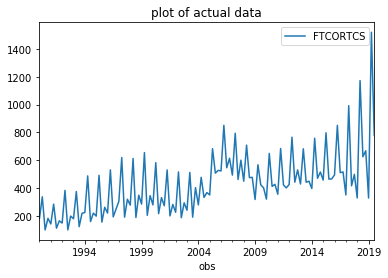

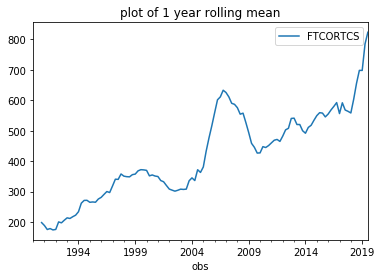

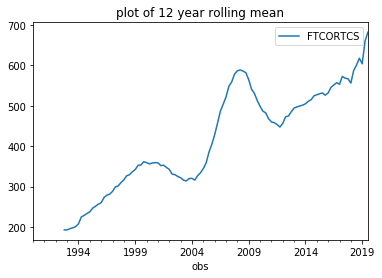

In [5]:
df[[forecast_variable]].plot()
plt.title('plot of actual data')

df[[forecast_variable]].rolling(4).mean().plot()
plt.title('plot of 1 year rolling mean')
df[[forecast_variable]].rolling(12).mean().plot()
plt.title('plot of 12 year rolling mean')


#### Train test split

In [6]:
n_test= n_test # 8 quarters in test data<-- make it 0 to forecast
n_train= df.shape[0]-n_test

train_df= df[:n_train]
test_df= df[-n_test:]

#### Feature Standardization

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train_df)
train_df= scaler.transform(train_df)
#test_df= scaler.transform(test_df)
scaler.inverse_transform(train_df)
#scaler.scale_[-1]


output_length= output_length
#train length: taking train
#train_length= round(1.5*output_length)


#### Transform data for neural network training

In [8]:

def data_transform(train_df, train_length, output_length):
    samples=list()
    #length = 200
    # step over the 5,000 in jumps of 200
    i=0
    for i in range(0,train_df.shape[0]+1-train_length-output_length):
        # grab from i to i + 200
        sample = train_df[i:i+train_length+output_length]
        samples.append(sample)
    print(len(samples))
    #np.array(samples).reshape(5,4)
    A= np.dstack(samples)
    A.shape
    A_new= np.moveaxis(A, -1, 0)
    A_new.shape
    #it creates n+1- (length+output_length) number of samples
    samples[0]
    X, Y= A_new[:,:train_length,:], A_new[:,train_length:,0]
    return X, Y

X, Y = data_transform(train_df, train_length ,output_length)
#A_test= data_transform(test_df)

102


#### Prepare train and validation set

In [9]:
import tensorflow as tf
from tensorflow import keras

valid_split= 0.20
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size= valid_split, random_state=1234 )
Y.shape
X.shape

X_train.shape
#(74,12,10)
X_valid.shape
#(18,12,10)
Y_train.shape
#(74,8)


np.random.seed(42)
tf.random.set_seed(42)

#### Define the model

In [22]:
##lstm
model = keras.models.Sequential([
    keras.layers.GRU(20, activation='relu', return_sequences=True, input_shape=[X_train.shape[1], X_train.shape[2]]),
    #keras.layers.GRU(20, activation='relu', return_sequences=True),
    keras.layers.Dropout(.2),

    keras.layers.GRU(10),
    #keras.layers.TimeDistributed(keras.layers.Dense(10))
    keras.layers.Dense(output_length)

])


#### Compile the model

In [23]:
model.compile(loss="mae", optimizer="adam")

#### Fit the model

Train on 81 samples, validate on 21 samples
Epoch 1/50
81/81 [==============================] - 7s 90ms/sample - loss: 0.2621 - val_loss: 0.2168
Epoch 2/50
81/81 [==============================] - 0s 599us/sample - loss: 0.1957 - val_loss: 0.1538
Epoch 3/50
81/81 [==============================] - 0s 592us/sample - loss: 0.1598 - val_loss: 0.1238
Epoch 4/50
81/81 [==============================] - 0s 494us/sample - loss: 0.1478 - val_loss: 0.1275
Epoch 5/50
81/81 [==============================] - 0s 593us/sample - loss: 0.1429 - val_loss: 0.1300
Epoch 6/50
81/81 [==============================] - 0s 494us/sample - loss: 0.1393 - val_loss: 0.1335
Epoch 7/50
81/81 [==============================] - 0s 494us/sample - loss: 0.1364 - val_loss: 0.1349
Epoch 8/50
81/81 [==============================] - 0s 644us/sample - loss: 0.1384 - val_loss: 0.1331
Epoch 9/50
81/81 [==============================] - 0s 643us/sample - loss: 0.1400 - val_loss: 0.1274
Epoch 10/50
81/81 [====================

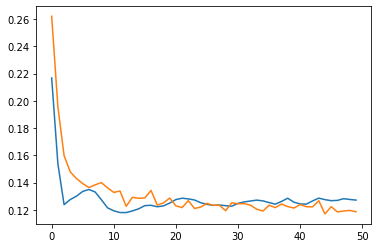

In [24]:
n_epochs= 50
history = model.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid))
model.input_shape
model.output_shape

model.summary()
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(x= range(0, n_epochs), y= history.history['val_loss'])
sns.lineplot(x= range(0, n_epochs), y= history.history['loss'])


#### preprocess the whole data

In [25]:
#i: index location of last point in training
#forecast_iterations: number of iterations to be the forecast loop will run. 
#Forecast points= output_length* forecast_iterations

def forecast(df_complete, i, forecast_iterations ):

    
    #scale the dataframe 
    df_complete_updated = df_complete*scaler.scale_
    #iterate till we have all required number of forecast points

    for iter in range(0,forecast_iterations):
        # for each iteration
        #1  Extract the model input
        temp= df_complete_updated[(df_complete_updated.index<= df_complete_updated.index[i]).astype(bool) & (df_complete_updated.index> df_complete_updated.index[i-train_length]).astype(bool)]
        #2  turn datframe into array and Shape it as required bythe model
        model_input= temp.values.reshape(1,train_length,df_complete.shape[1])

        #validate that correct transformation has been done

        model_input[0,:,0] # shows predictor variable latest 8 values in a scaled format
        #3) Pass it to the model and forecast the output
        model_output= model.predict(model_input)
        
        
        #4) update the values in the dataframe with the forecasted values
        
        df_complete_updated.loc[
                    df_complete_updated.index[i+1:i+1+output_length]

            ,forecast_variable]= model_output
        
        #5) Update the index- index location of the last observation of model input array
        i= i+output_length
    
    #inverse transform scaling to obtain original values. This is done at once after all iterations have been done.
    df_complete_updated= df_complete_updated/ scaler.scale_
    
    return df_complete_updated

#### Prepare data to validate on the test set

In [26]:
i= 110
forecast_iterations =int(n_test/output_length) # 8/4
import tensorflow as tf

df_complete_updated_test= forecast(df_complete, i, forecast_iterations)

#### Prepare data to forecast on the complete set

In [27]:
i= 118
forecast_iterations =int(forecast_points/output_length)# 40/4

df_complete_updated_forecast= forecast(df_complete, i, forecast_iterations)

#### Combine all three data for plotting purpose

In [28]:
import numpy as np

plot_data= pd.concat([
           df_complete_updated_test[forecast_variable],
           df_complete_updated_forecast[forecast_variable],
            df_complete[forecast_variable]], axis=1)
plot_data.columns= ['test','predicted', 'actual']
type(plot_data.predicted[-1])
plot_data.loc[plot_data.index<='2017Q3','test']=np.nan
plot_data.loc[plot_data.index>'2019Q3','test']=np.nan

plot_data.loc[plot_data.index<='2019Q3','predicted']=np.nan

#### Comparison of accuracy on test set

Text(0.5, 1.0, 'comparison of last 2 years output with actual')

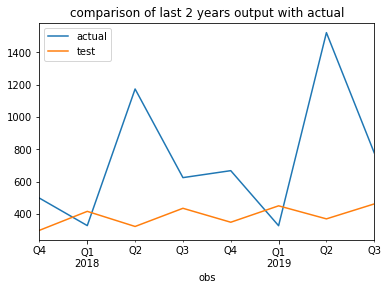

In [29]:
plot_data[['actual', 'test']][111:119].plot()
plt.title('comparison of last 2 years output with actual')

#### Computing performance and storing it in a file

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np 
from math import sqrt
print("MAE")
mae= mean_absolute_error(plot_data[111:119].actual.values, plot_data[111:119].test.values)
print(mae)
print("RSME")
rmse= sqrt(mean_squared_error(plot_data[111:119].actual.values, plot_data[111:119].test.values))
print(rmse)


MAE
404.5275384468083
RSME
541.857472393595


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from numpy import math
metrics= pd.read_csv('E:/Python WD/time_series/data/metrics.csv', index_col='Unnamed: 0')
metrics.loc['mean absolute error', 'GRU']= mae
print('mean absolute error: '+str(mae))
metrics.loc['mean squared error', 'GRU']= rmse
print('root mean squared error: '+str(rmse))

metrics.to_csv('E:/Python WD/time_series/data/metrics.csv')
#metrics

mean absolute error: 404.5275384468083
root mean squared error: 541.857472393595


#### Forecast for next 10 years

Text(0.5, 1.0, 'forecast of next 10 years data')

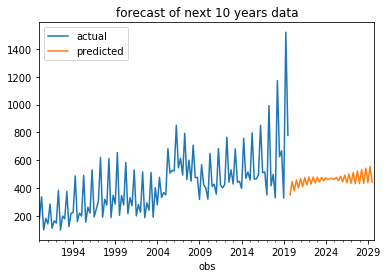

In [32]:
plot_data[['actual','predicted']].plot()
plt.title('forecast of next 10 years data')

#### Storing the forecasts for next 10 years

In [33]:
predictions= pd.read_csv('E:/Python WD/time_series/data/predictions.csv', index_col= 'Unnamed: 0')
#obtain predictions for next 10 years
temp= plot_data[plot_data.index>'2019Q3'][['predicted']][0:40]
predictions.loc[:,'GRU']=temp.values
predictions.to_csv('E:/Python WD/time_series/data/predictions.csv')